# Import bibliotek

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from matplotlib.colors import ListedColormap

In [2]:
data_rfm = pd.read_parquet('df.parquet')

### Features Used in training K Means - Log Transformed Recency, Frequency and Monetary values
data_norm = data_rfm[["log_R", "log_F", "log_M"]]

# Dobór parametrów
Aby dobrać parametry trzeba użyć metody łokieto

Wybieramy 3

# Algorytm

In [3]:
from sklearn.cluster import Birch

n_clusters = 4

model = Birch(n_clusters=n_clusters)
clusters = model.fit_predict(data_norm)


data_rfm['Cluster']= clusters


# Analiza wyników

### Wykresy

In [4]:
sns.set_style("whitegrid")
data_rfm['Cluster'] = data_rfm['Cluster'].apply(str)

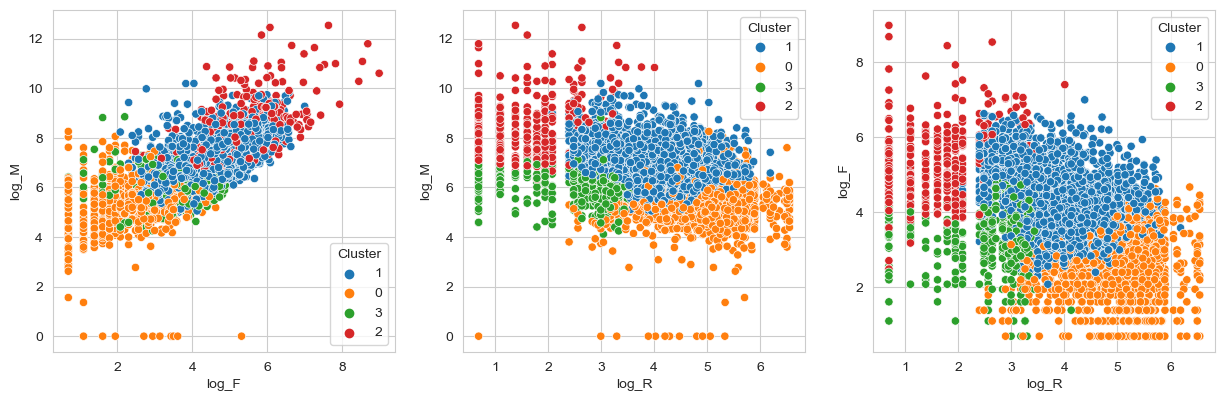

In [5]:
f, axes = plt.subplots(1, 3, subplot_kw=dict(box_aspect=1), figsize=(15, 15))
sns.scatterplot(data=data_rfm, x='log_F', y='log_M', hue='Cluster', ax=axes[0])
sns.scatterplot(data=data_rfm, x='log_R', y='log_M', hue='Cluster', ax=axes[1])
sns.scatterplot(data=data_rfm, x='log_R', y='log_F', hue='Cluster', ax=axes[2])

plt.show()

In [6]:
print(data_rfm['Cluster'].dtype)

object


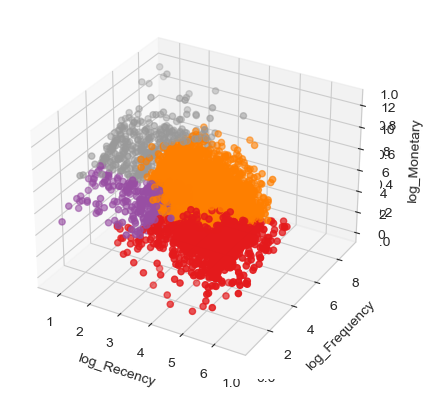

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')
cmap = ListedColormap(sns.color_palette("Set1", 256).as_hex())
sns_plot = plt.axes (projection='3d')
sns_plot.scatter3D(data_rfm['log_R'], data_rfm['log_F'], data_rfm['log_M'],
                       c=data_rfm['Cluster'].apply(int), cmap=cmap)
sns_plot.set_xlabel ('log_Recency')
sns_plot.set_ylabel ('log_Frequency')
sns_plot.set_zlabel ('log_Monetary')
plt.show ()

### Analiza biznesowa

In [8]:
df_table = data_rfm.groupby('Cluster').agg({'Cluster': 'count','R_score': 'mean', 'F_score': 'mean', 'M_score':'mean', 'RFM_Score':'mean'})

df_result = data_rfm.groupby('Cluster').agg({'Cluster': 'count','R_score': 'mean', 'F_score': 'mean', 'M_score':'mean', 'RFM_Score':'mean'}).round(2)

df_result = df_result.rename_axis('Klaster').rename(columns={
    'Cluster': 'Liczba klientów',
    'R_score': 'Wartość R',
    'F_score': 'Wartość F',
    'M_score': 'Wartość M',
    'RFM_Score': 'Wartość RFM'
})

df_result

,Liczba klientów,Wartość R,Wartość F,Wartość M,Wartość RFM
Klaster,,,,,
0,1211,0.47,0.36,0.38,1.21
1,2370,1.63,2.00,2.01,5.64
2,346,2.96,2.70,2.76,8.43
3,402,2.80,1.03,0.92,4.75


In [9]:
with open("csv_table.tex", 'w') as f:
    f.write(df_result.to_latex(index=True))

C:\Users\marce\AppData\Local\Temp\ipykernel_488\191917624.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(df_result.to_latex(index=True))


In [10]:
def assign_label_Recency(value):
    print(value)
    if 0 < value <= 1:
        return 'Utracony'
    elif 1 < value <= 2:
        return 'Odchodzący'
    elif 2 < value <= 3:
        return 'Aktywny'


def assign_label_Frequency_or_Monetary(value):
    if 0 < value <= 1:
        return 'Niska'
    elif 1 < value <= 2:
        return 'Średnia'
    elif 2 < value <= 3:
        return 'Wysoka'

def assign_label_Frequency_and_Monetary(value):
    if 0 < value <= 1:
        return 'Niska'
    elif 1 < value <= 2:
        return 'Średnia'
    elif 2 < value <= 3:
        return 'Wysoka'

df = df_table.copy()

df['Aktywność klienta'] = df['R_score'].apply(assign_label_Recency)
df['Częstotliwość zakupów'] = df['F_score'].apply(assign_label_Frequency_and_Monetary)
df['Wartość monetarna'] = df['M_score'].apply(assign_label_Frequency_and_Monetary)
df['Kategoria klientów R, F i M'] = df.apply(lambda row: f"{row['Aktywność klienta']}, {row['Częstotliwość zakupów']} częstotliwość, {row['Wartość monetarna']} wartość monetarna", axis=1)
# Definiowanie funkcji przypisującej etykiety na podstawie wartości z kolumny 2 i Avg_FM
def assign_label_R_vs_FM(row):
    print(row)
    r_value = row['R_score']
    fm_value = (row['F_score'] + row['M_score']) / 2

    if 2 < r_value <= 3:
        if 2 < fm_value <= 3:
            fm_label = 'Czempioni'
        elif 1 < fm_value <= 2:
            fm_label = 'Obiecujący'
        elif 0 < fm_value <= 1:
            fm_label = 'Nowi klienci'

    elif 1 < r_value <= 2:
        if 2 < fm_value <= 3:
            fm_label = 'Lojalni klienci'
        elif 1 < fm_value <= 2:
            fm_label = 'Wymagają uwagi'
        elif 0 < fm_value <= 1:
            fm_label = 'Powinno się skontaktować'

    elif 0 < r_value <= 1:
        if 2 < fm_value <= 3:
            fm_label = 'Nie powinno się stracić'
        elif 1 < fm_value <= 2:
            fm_label = 'Odchodzący'
        elif 0 < fm_value <= 1:
            fm_label = 'Utraceni'

    return fm_label

df['Kategoria klientów R vs FM'] = df.apply(lambda row : assign_label_R_vs_FM(row), axis=1)

df = df.drop(columns=['RFM_Score', 'R_score', 'F_score', 'M_score'])
print(df)

0.4715111478117259
1.6282700421940928
2.96242774566474
2.800995024875622
Cluster                                                                     1211
R_score                                                                 0.471511
F_score                                                                  0.36251
M_score                                                                 0.377374
RFM_Score                                                               1.211396
Aktywność klienta                                                       Utracony
Częstotliwość zakupów                                                      Niska
Wartość monetarna                                                          Niska
Kategoria klientów R, F i M    Utracony, Niska częstotliwość, Niska wartość m...
Name: 0, dtype: object
Cluster                                                                     2370
R_score                                                                  1.62827
F_score      

### Analiza klastrów

In [11]:
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score
from validclust import dunn
from sklearn.metrics import pairwise_distances

print(f'Wskaznik sylwetki: {silhouette_score(data_norm, data_rfm["Cluster"]).round(2)}')
print(f'Indeks CH: {calinski_harabasz_score(data_norm, data_rfm["Cluster"]).round(2)}')
print(f'Indeks DB: {davies_bouldin_score(data_norm, data_rfm["Cluster"]).round(2)}')
print(f'Indeks Dunn: {dunn(pairwise_distances(data_norm, metric="cityblock"), data_rfm["Cluster"]).round(5)}')

Wskaznik sylwetki: 0.23
Indeks CH: 1779.53
Indeks DB: 1.11
Indeks Dunn: 0.00383


### Analiza algorytmu

In [12]:
import timeit

n = 10
stmt = '''
model = Birch(n_clusters=n_clusters)
clusters = model.fit_predict(data_norm)
'''
result = timeit.timeit(stmt=stmt, globals=globals(), number=n)

print(f"Średni czas wykonania wynosi  {round(result / n, 3)} sekund")

Średni czas wykonania wynosi  0.137 sekund


In [13]:
import pandas as pd
from scipy.spatial.distance import euclidean
import sys

def intra_cluster_distance(cluster_points):
    distances = []
    for i in range(len(cluster_points)):
        for j in range(i+1, len(cluster_points)):
            distances.append(euclidean(cluster_points[i], cluster_points[j]))
    return max(distances) if distances else 0

def inter_cluster_distance(c1_points, c2_points):
    distances = []
    for point1 in c1_points:
        for point2 in c2_points:
            distances.append(euclidean(point1, point2))
    return min(distances) if distances else sys.maxsize

def dunn_index(data_norm, data_clusters):
    clusters = data_clusters.unique()
    clustered_points = {cluster: data_norm[data_clusters == cluster].values.tolist() for cluster in clusters}
    max_intra_cluster_dist = max([intra_cluster_distance(cluster_points) for cluster_points in clustered_points.values()])

    min_inter_cluster_dist = sys.maxsize
    for i, cluster1 in enumerate(clusters[:-1]):
        for cluster2 in clusters[i+1:]:
            dist = inter_cluster_distance(clustered_points[cluster1], clustered_points[cluster2])
            min_inter_cluster_dist = min(min_inter_cluster_dist, dist)

    return min_inter_cluster_dist / max_intra_cluster_dist

# Read data_norm from CSV or create a pandas DataFrame with three columns for coordinates
# data_norm = pd.read_csv('data_norm.csv')
# data_rfm = pd.read_csv('data_rfm.csv')

# Example: Creating a pandas DataFrame for demonstration purposes


# Calculate Dunn Index
result = dunn_index(data_norm, data_rfm['Cluster'])

print(f'Dunn Index: {result}')

Dunn Index: 0.0043922605908407915
